# Homework 10

In this homework, you will implement NN using PyTorch and investigate different activation functions, batch sizes, and learning rates. Use [Lecture code](https://github.com/anton-selitskiy/RIT_ML/blob/main/2025_spring/Week11_MLP/ML21.ipynb) as refference.

Use load_planar_dataset function from the previous homework to create the data.

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [14]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

##1. (2 pt) Create Dataset object.

In [15]:
X, y = load_planar_dataset()
y = y.reshape(-1, 1)

class PlanarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = PlanarDataset(X, y)

## 2. (1 pt) Create DataLoader object.

In [16]:
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 3. (3 pt) Construct the model
$$
hidden\_1 \to activation\_1 \to hidden\_2 \to activation\_2  
$$
Use `Sigmoid` function as activation on this step.

In [17]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size=2, hidden1=8, hidden2=4, output_size=1):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.activation1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.activation2 = nn.Sigmoid()
        self.output = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.output(x)
        return x

model = MyModel()

## 4. (3 pt) Write the training loop. Use Binary cross-entropy loss. Also, you can use tqdm function to see the training progress. You can start with learning rate 0.01.

In [19]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

In [20]:
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [21]:
num_epochs = 100
loss_history = []

In [22]:
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for x_batch, y_batch in data_loader:
      optimizer.zero_grad()
      outputs = model(x_batch)
      loss = criterion(outputs, y_batch)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(data_loader))

100%|██████████| 100/100 [00:02<00:00, 45.10it/s]


## 5. (2 pt) Write the prediction class to use it in plot_decision_regions function.

In [23]:
class PredictionClass:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
      with torch.no_grad():
          X_tensor = torch.tensor(X, dtype=torch.float32)
          logits = self.model(X_tensor)
          probs = torch.sigmoid(logits)
          return (probs.numpy() > 0.5).astype(np.int32).ravel()

## 6. (2 pt) Plot the loss and decision boundary after the training.

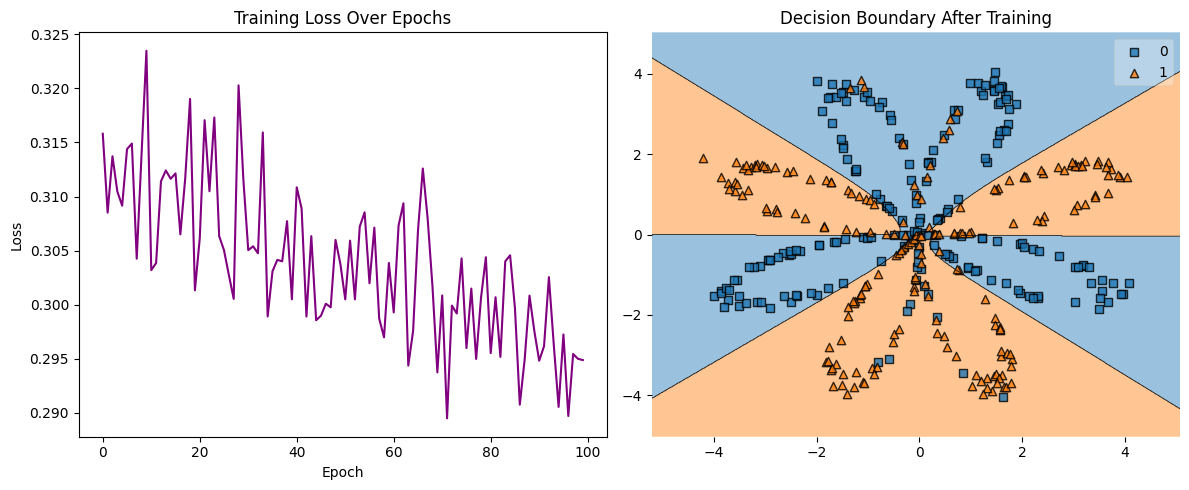

In [37]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# training loss
axs[0].plot(loss_history, color='purple')
axs[0].set_title("Training Loss Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

# decision boundary
wrapped_model = PredictionClass(model)
plot_decision_regions(X, y.flatten(), clf=wrapped_model, ax=axs[1])
axs[1].set_title("Decision Boundary After Training")

plt.tight_layout()
plt.show()


## 7. Experiments 1: Try LeakyReLU as `activation_1` with the size of `hidden_1` = 4, 5, and 10. You can reuse the same model without copying it.

In [38]:
class Experiment1Model(nn.Module):
    def __init__(self, input_size=2, hidden1=5, hidden2=4, output_size=1, activation_1=nn.Sigmoid()):
        super(Experiment1Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.activation1 = activation_1
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.activation2 = nn.Sigmoid()
        self.output = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        return self.output(x)

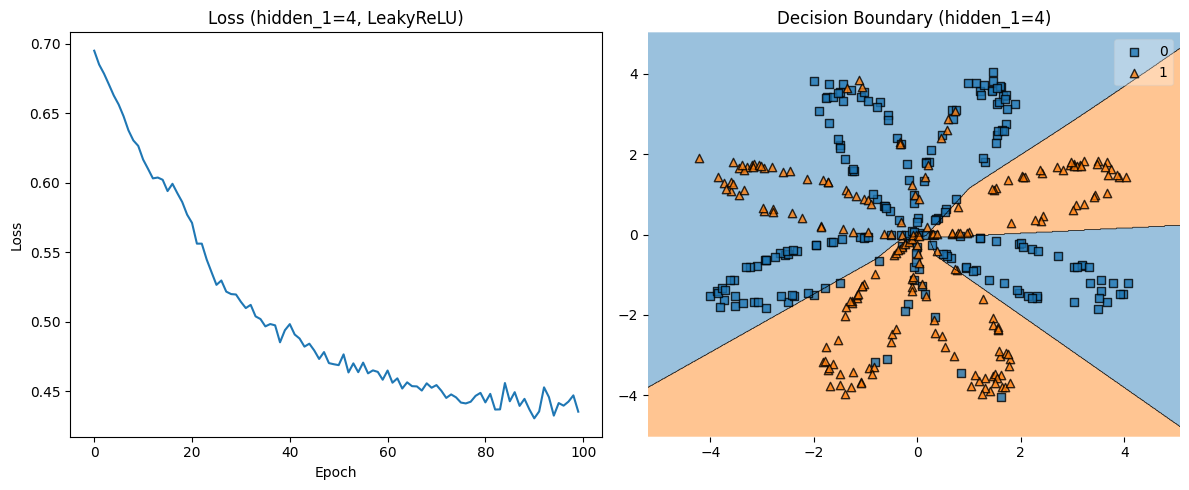

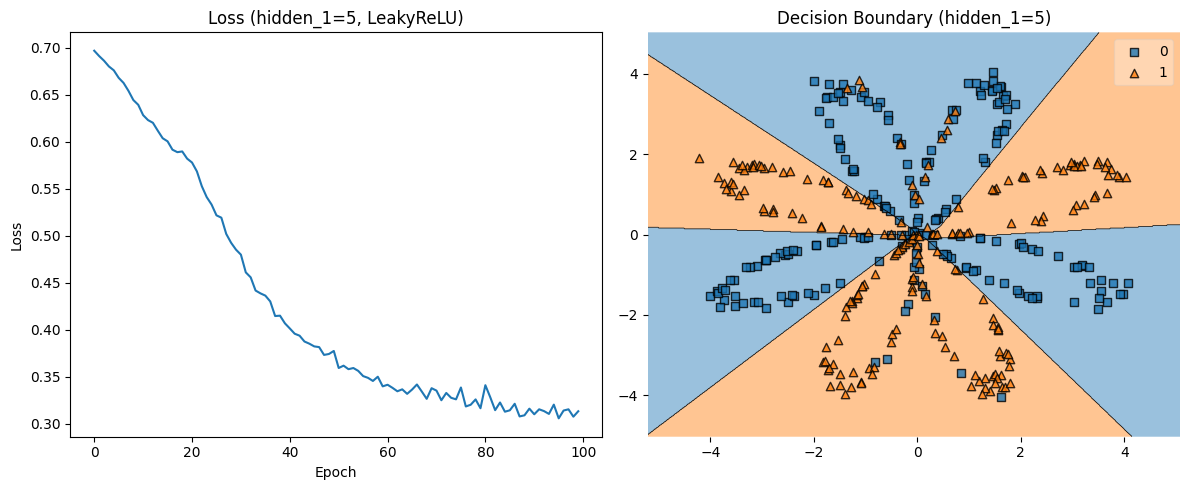

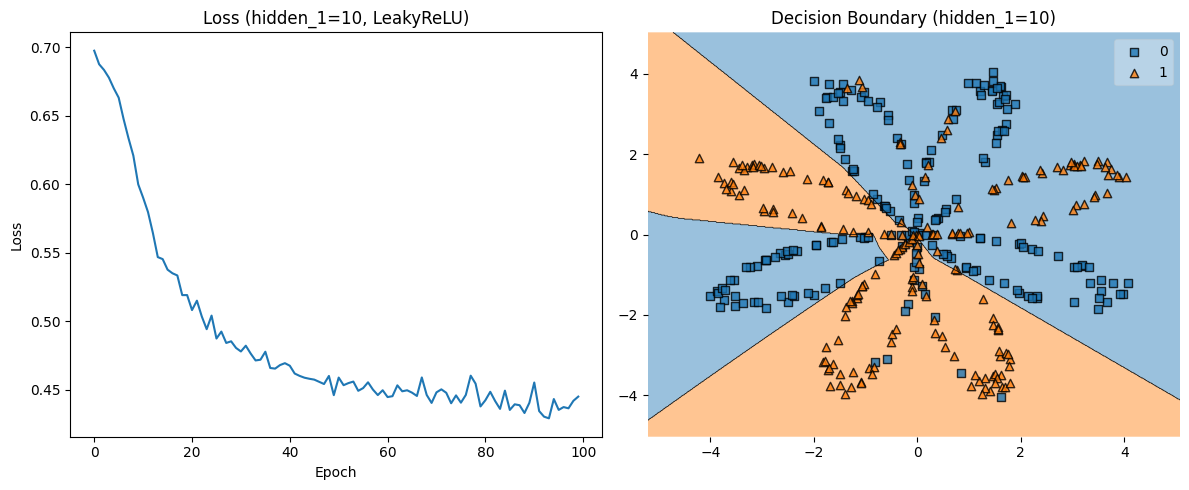

In [42]:
from torch.nn import LeakyReLU

hidden_sizes = [4, 5, 10]

for hidden_size in hidden_sizes:
    model = Experiment1Model(hidden1=hidden_size, activation_1=LeakyReLU())
    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    num_epochs = 100
    loss_history = []

    for epoch in range(num_epochs):
      epoch_loss = 0.0
      for x_batch, y_batch in data_loader:
          optimizer.zero_grad()
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      loss_history.append(epoch_loss / len(data_loader))

    # plot results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(loss_history)
    axs[0].set_title(f"Loss (hidden_1={hidden_size}, LeakyReLU)")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")

    wrapped_model = PredictionClass(model)
    plot_decision_regions(X, y.flatten(), clf=wrapped_model, ax=axs[1])
    axs[1].set_title(f"Decision Boundary (hidden_1={hidden_size})")

    plt.tight_layout()
    plt.show()

## 8. (3 pt) Comment on the number of the straight lines with respect to the size of the hidden layer.

As the hidden layer gets larger, the model creates more straight lines to separate the classes. With more lines, it can divide the space into smaller regions, which helps it better follow the shape of the data. This makes the decision boundary more detailed and improves how well the model fits complex patterns.

## 9. Experiments 2: with the `hidden_1` layer of the size 4 try Sigmoind, ReLU, LeakyReLU, ELU, and SiLU as `activation_1`. Do this for batch sizes 4 and 50.

In [52]:
from torch.nn import Sigmoid, ReLU, LeakyReLU, ELU, SiLU

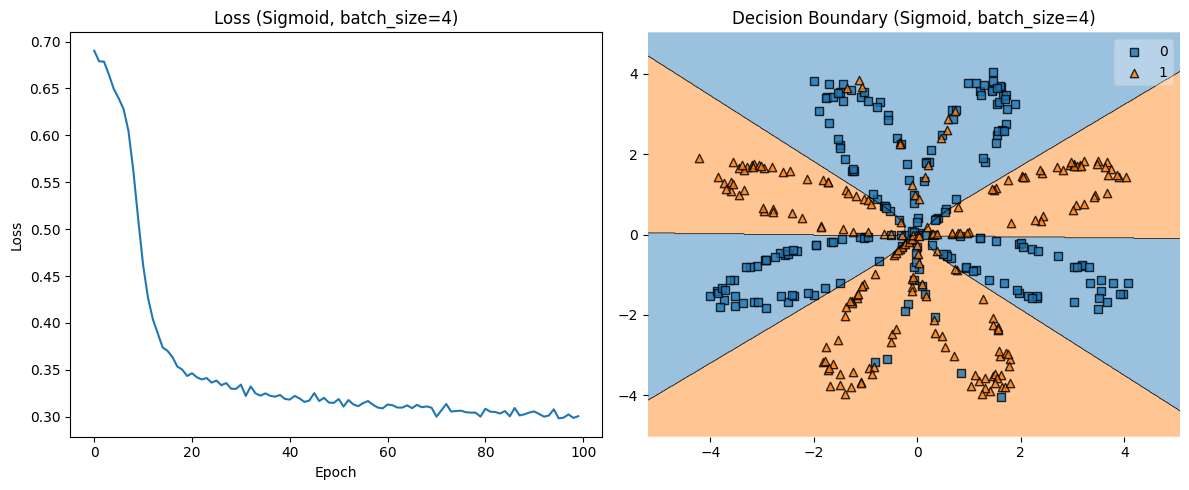

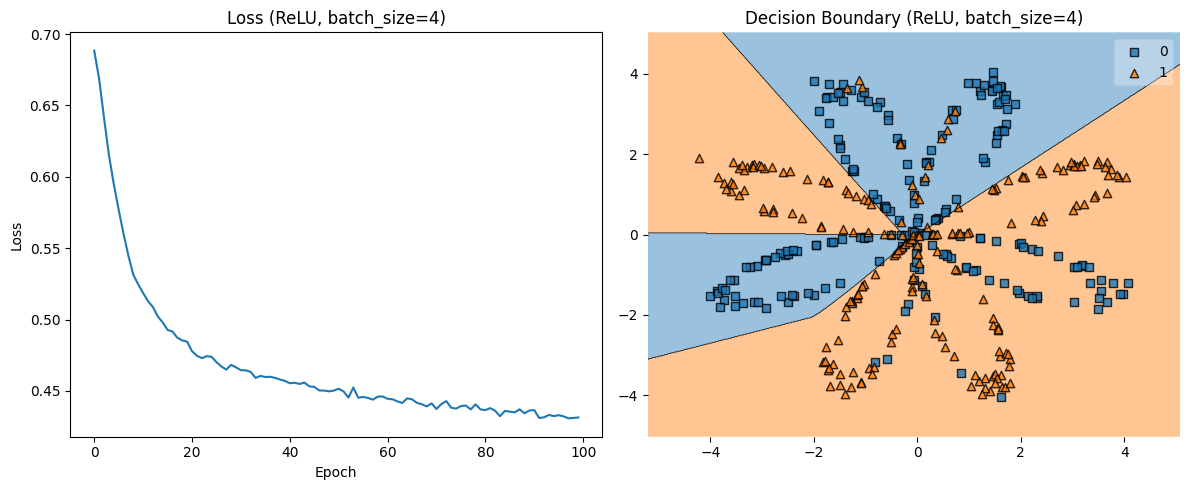

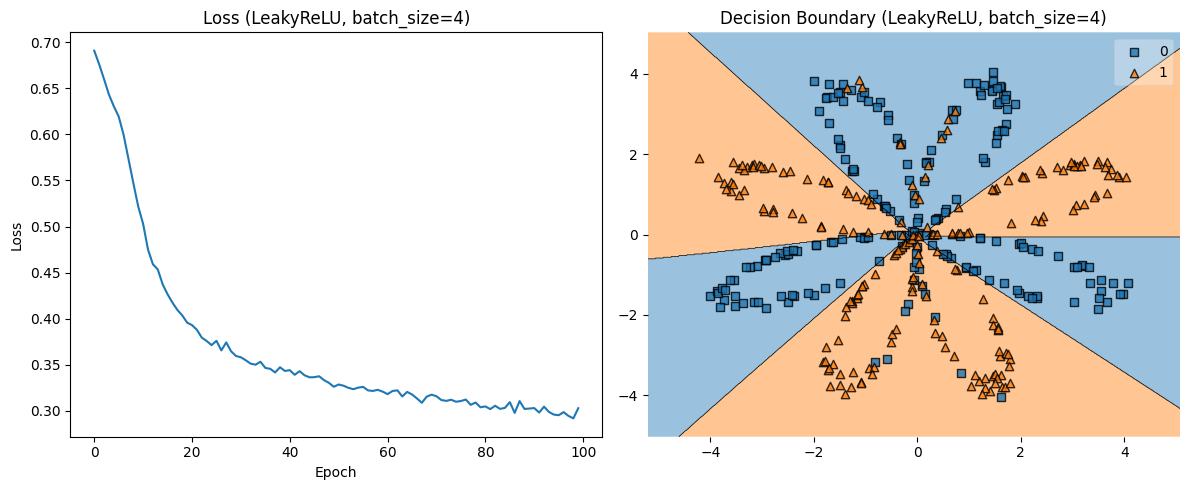

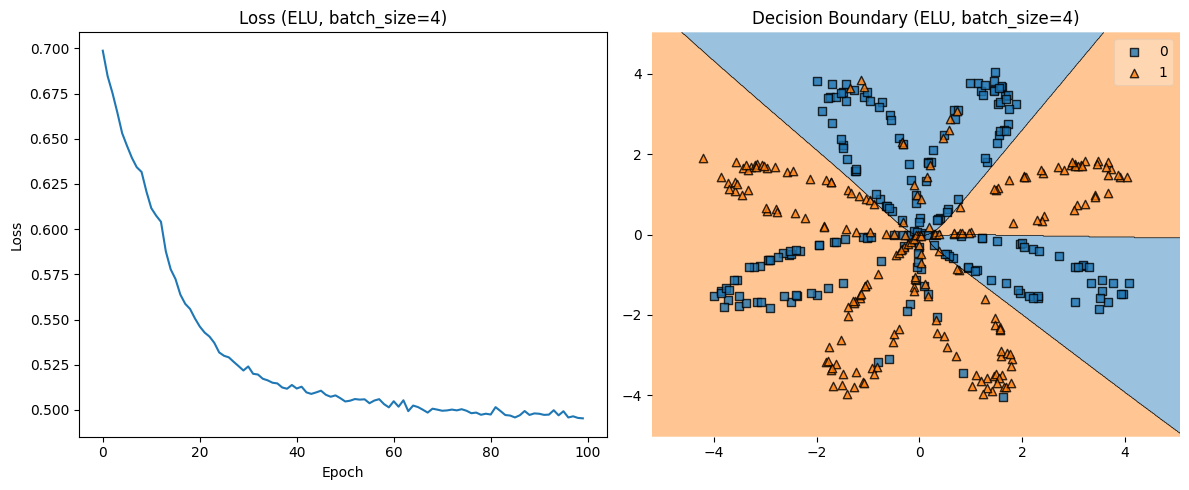

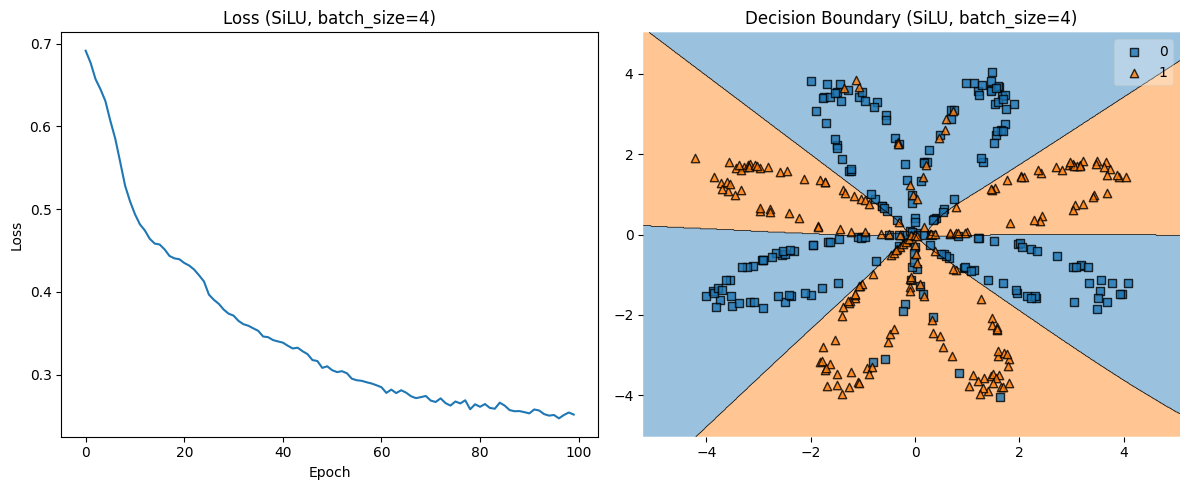

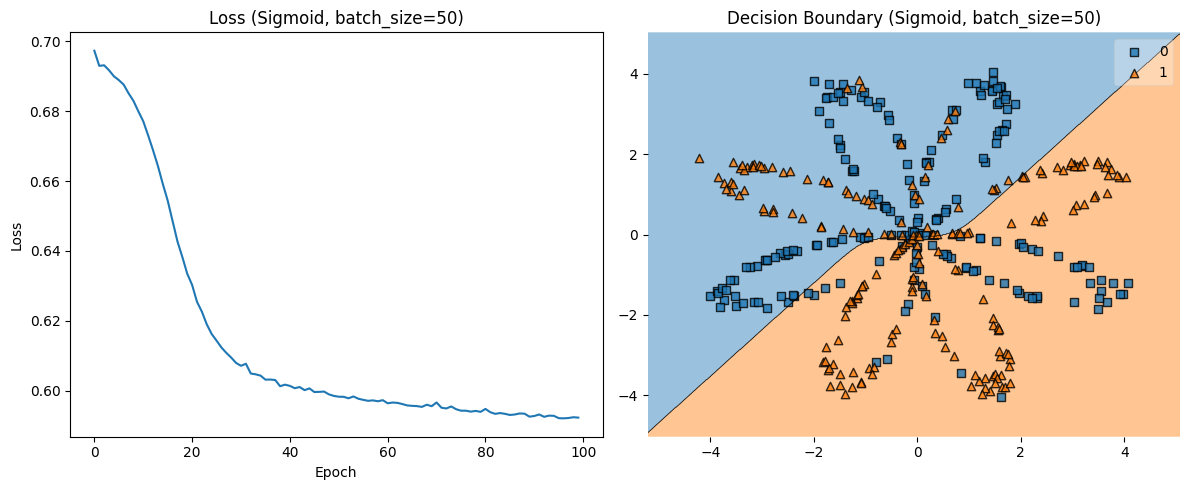

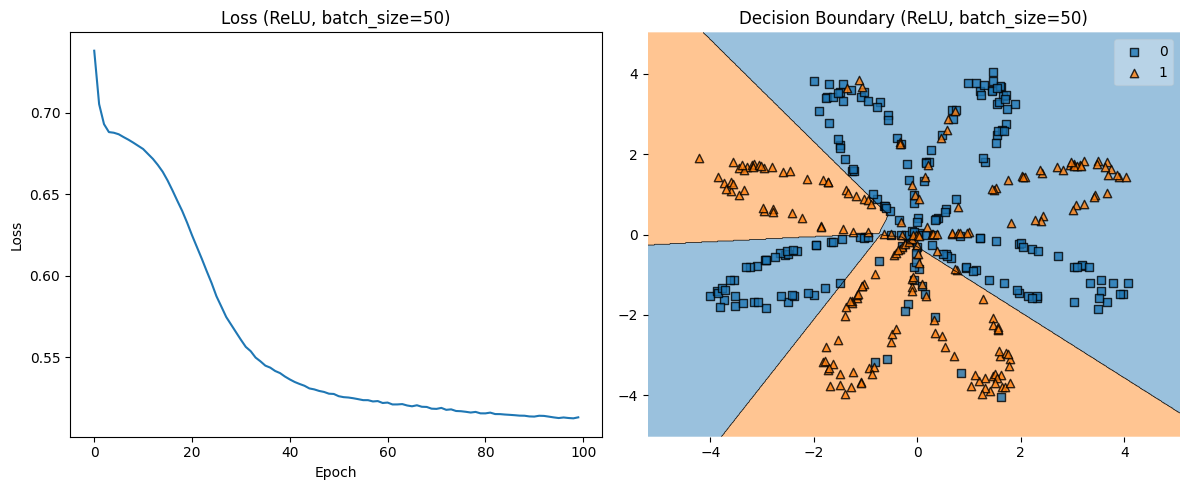

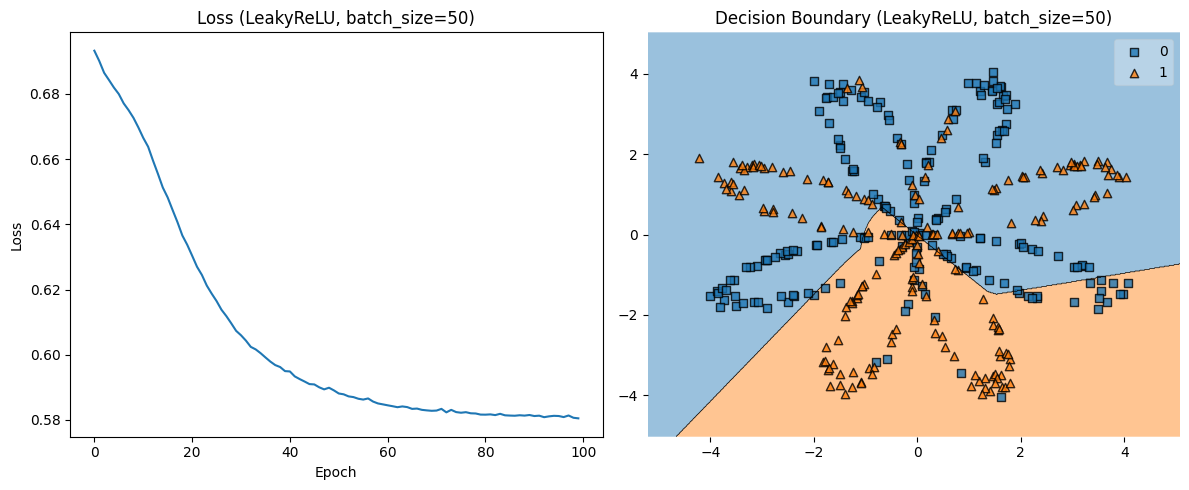

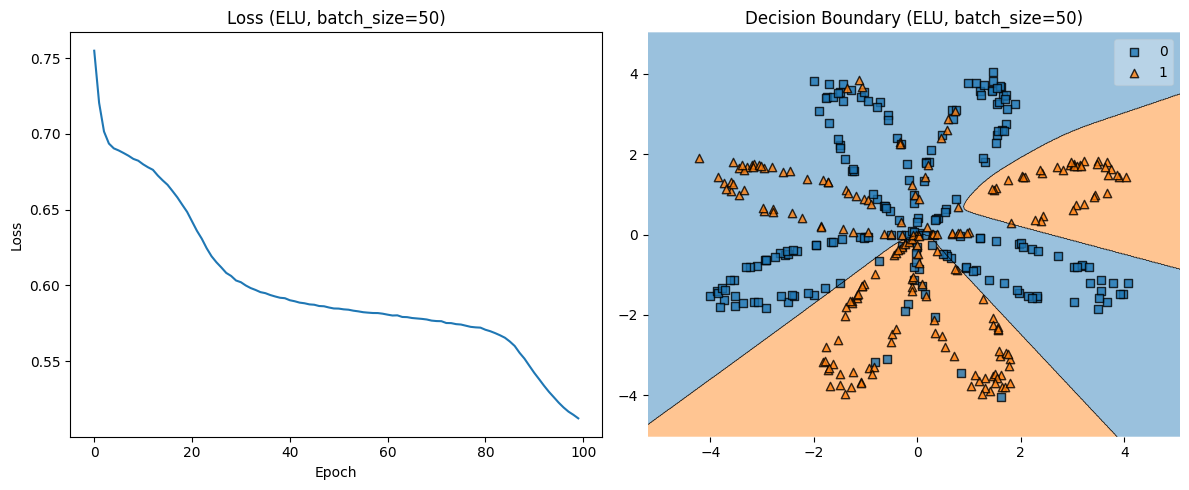

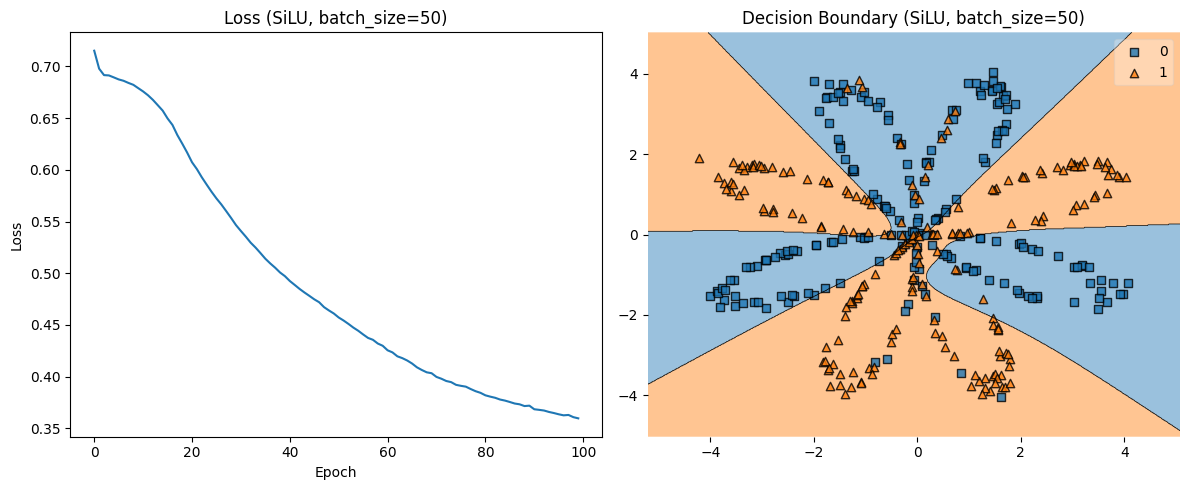

In [54]:
activations = [Sigmoid(), ReLU(), LeakyReLU(), ELU(), SiLU()]
batch_sizes = [4, 50]

for batch_size in batch_sizes:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for activation in activations:
        model = Experiment1Model(hidden1=4, activation_1=activation)
        criterion = BCEWithLogitsLoss()
        optimizer = Adam(model.parameters(), lr=0.01)
        num_epochs = 100
        loss_history = []

        for epoch in range(num_epochs):
          epoch_loss = 0.0
          for x_batch, y_batch in data_loader:
              optimizer.zero_grad()
              outputs = model(x_batch)
              loss = criterion(outputs, y_batch)
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()
          loss_history.append(epoch_loss / len(data_loader))

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].plot(loss_history)
        axs[0].set_title(f"Loss ({activation.__class__.__name__}, batch_size={batch_size})")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")

        wrapped_model = PredictionClass(model)
        plot_decision_regions(X, y.flatten(), clf=wrapped_model, ax=axs[1])
        axs[1].set_title(f"Decision Boundary ({activation.__class__.__name__}, batch_size={batch_size})")

        plt.tight_layout()
        plt.show()


## 10. (4 pt) Comment on the shape of the decision boundaries with respect to the activation function and the batch size. Did you adjust the learning rate? Did you try to start with small learning rate like 0.001 instead of 0.01 and if so, which worked better?

Activation functions like ReLU, LeakyReLU, ELU, and SiLU created sharper, more complex boundaries compared to Sigmoid, which produced smoother but simpler boundaries. Among these, SiLU and ELU gave the most natural and smooth decision curves while still capturing the structure of the data well.

Batch size also played a big role. With smaller batch size (4), the model made more frequent updates, which led to more flexible and detailed boundaries but noisier training curve. With larger batch size (50), the boundaries were smoother and more stable, but sometimes too simple to fully fit the complex data.

I also tried adjusting the learning rate, testing with 0.001 and 0.01. The smaller learning rate (0.001)led to slower but more stable training and resulted in smoother decision boundaries. While 0.01 converged faster, 0.001 gave cleaner and more refined boundaries in some cases.